# Chapter 6: Multiple Linear Regression

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

In [3]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

%matplotlib inline


## Table 6.3

In [5]:
# Reduce data frame to the top 1000 rows and select columns for regression analysis
car_df = pd.read_csv('C:/1. Yuke/Master 1st semester/MMAI5000_AI/ToyotaCorolla.csv')
car_df = car_df.iloc[0:1000]

predictors = ['Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 
              'Doors', 'Quarterly_Tax', 'Weight']
outcome = 'Price'

# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', car_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

# print performance measures
regressionSummary(train_y, car_lm.predict(train_X))

intercept  -1319.3543800412026
           Predictor  coefficient
0          Age_08_04  -140.748761
1                 KM    -0.017840
2                 HP    36.103419
3          Met_Color    84.281830
4          Automatic   416.781954
5                 CC     0.017737
6              Doors   -50.657863
7      Quarterly_Tax    13.625325
8             Weight    13.038711
9   Fuel_Type_Diesel  1066.464681
10  Fuel_Type_Petrol  2310.249543

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1400.5823
            Mean Absolute Error (MAE) : 1046.9072
          Mean Percentage Error (MPE) : -1.0223
Mean Absolute Percentage Error (MAPE) : 9.2994


In [6]:
pred_y = car_lm.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, car_lm))
print('AIC : ', AIC_score(train_y, pred_y, car_lm))
print('BIC : ', BIC_score(train_y, pred_y, car_lm))

adjusted r2 :  0.8537958550253093
AIC :  10422.298278332171
BIC :  10479.45836384998


## Table 6.4

In [7]:
# Use predict() to make predictions on a new set
car_lm_pred = car_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': car_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - car_lm_pred})
print(result.head(20))

# Compute common accuracy measures
regressionSummary(valid_y, car_lm_pred)

        Predicted  Actual     Residual
507  10607.333940   11500   892.666060
818   9272.705792    8950  -322.705792
452  10617.947808   11450   832.052192
368  13600.396275   11450 -2150.396275
242  12396.694660   11950  -446.694660
929   9496.498212    9995   498.501788
262  12480.063217   13500  1019.936783
810   8834.146068    7950  -884.146068
318  12183.361282    9900 -2283.361282
49   19206.965683   21950  2743.034317
446  10987.498309   11950   962.501691
142  18501.527375   19950  1448.472625
968   9914.690947    9950    35.309053
345  13827.299932   14950  1122.700068
971   7966.732543   10495  2528.267457
133  17185.242041   15950 -1235.242041
104  19952.658062   19450  -502.658062
6    16570.609280   16900   329.390720
600  13739.409113   11250 -2489.409113
496  11267.513740   11750   482.486260

Regression statistics

                      Mean Error (ME) : 103.6803
       Root Mean Squared Error (RMSE) : 1312.8523
            Mean Absolute Error (MAE) : 1017.5972
        

## Figure 6.1
Determine the residuals and create a histogram

0.7425


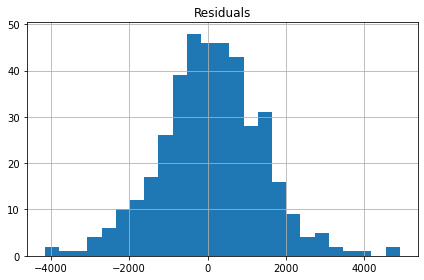

In [8]:
car_lm_pred = car_lm.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

## Table 6.5
Run an exhaustive search. The Fuel type column is categorical and needs to be converted into dummy variables.

In [9]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

     n     r2adj           AIC  Age_08_04  Automatic     CC  Doors  Fuel_Type_Diesel  \
0    1  0.767901  10689.712094       True      False  False  False             False   
1    2  0.801160  10597.910645       True      False  False  False             False   
2    3  0.829659  10506.084235       True      False  False  False             False   
3    4  0.846357  10445.174820       True      False  False  False             False   
4    5  0.849044  10435.578836       True      False  False  False             False   
5    6  0.853172  10419.932278       True      False  False  False             False   
6    7  0.853860  10418.104025       True      False  False  False              True   
7    8  0.854297  10417.290103       True       True  False  False              True   
8    9  0.854172  10418.789079       True       True  False   True              True   
9   10  0.854036  10420.330800       True       True  False   True              True   
10  11  0.853796  10422.298278  

## Table 6.6 backward elimination

In [10]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=10422.30
Step: score=10420.33, remove CC
Step: score=10418.79, remove Met_Color
Step: score=10417.29, remove Doors
Step: score=10417.29, remove None
['Age_08_04', 'KM', 'HP', 'Automatic', 'Quarterly_Tax', 'Weight', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol']


In [11]:
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

                      Mean Error (ME) : 103.3045
       Root Mean Squared Error (RMSE) : 1314.4844
            Mean Absolute Error (MAE) : 1016.8875
          Mean Percentage Error (MPE) : -0.2700
Mean Absolute Percentage Error (MAPE) : 8.9984


## Table 6.7 Forward selection

In [12]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=11565.07, constant
Step: score=10689.71, add Age_08_04
Step: score=10597.91, add HP
Step: score=10506.08, add Weight
Step: score=10445.17, add KM
Step: score=10435.58, add Quarterly_Tax
Step: score=10419.93, add Fuel_Type_Petrol
Step: score=10418.10, add Fuel_Type_Diesel
Step: score=10417.29, add Automatic
Step: score=10417.29, add None
['Age_08_04', 'HP', 'Weight', 'KM', 'Quarterly_Tax', 'Fuel_Type_Petrol', 'Fuel_Type_Diesel', 'Automatic']


In [13]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=11565.07, constant
Step: score=10689.71, add Age_08_04
Step: score=10597.91, add HP
Step: score=10506.08, add Weight
Step: score=10445.17, add KM
Step: score=10435.58, add Quarterly_Tax
Step: score=10419.93, add Fuel_Type_Petrol
Step: score=10418.10, add Fuel_Type_Diesel
Step: score=10417.29, add Automatic
Step: score=10417.29, unchanged None
['Age_08_04', 'HP', 'Weight', 'KM', 'Quarterly_Tax', 'Fuel_Type_Petrol', 'Fuel_Type_Diesel', 'Automatic']


## Table XX regularized methods

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

lasso = Pipeline([
    ['normalize', StandardScaler()],
    ['model', Lasso(alpha=1)],
])
lasso.fit(train_X, train_y)
regressionSummary(valid_y, lasso.predict(valid_X))

lasso_cv = Pipeline([
    ['normalize', StandardScaler()],
    ['model', LassoCV(cv=5)],
])
lasso_cv.fit(train_X, train_y)
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print('Lasso-CV chosen regularization: ', lasso_cv['model'].alpha_)
print(lasso_cv['model'].coef_)

ridge = Pipeline([
    ['normalize', StandardScaler()],
    ['model', Ridge(alpha=1)],
])
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))

bayesianRidge = Pipeline([
    ['normalize', StandardScaler()],
    ['model', BayesianRidge()],
])
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
print('Bayesian ridge chosen regularization: ', 
      bayesianRidge['model'].lambda_ / bayesianRidge['model'].alpha_)


Regression statistics

                      Mean Error (ME) : 104.4168
       Root Mean Squared Error (RMSE) : 1313.2944
            Mean Absolute Error (MAE) : 1017.6609
          Mean Percentage Error (MPE) : -0.2619
Mean Absolute Percentage Error (MAPE) : 9.0100

Regression statistics

                      Mean Error (ME) : 132.4317
       Root Mean Squared Error (RMSE) : 1360.7243
            Mean Absolute Error (MAE) : 1034.4871
          Mean Percentage Error (MPE) : -0.2610
Mean Absolute Percentage Error (MAPE) : 9.1337
Lasso-CV chosen regularization:  52.81252993972756
[-2344.72733104  -638.64821716   509.86847033     0.
    44.37403325     0.            -0.           299.72739261
   757.83746697    -0.           188.03203033]

Regression statistics

                      Mean Error (ME) : 104.3792
       Root Mean Squared Error (RMSE) : 1312.8865
            Mean Absolute Error (MAE) : 1017.4566
          Mean Percentage Error (MPE) : -0.2657
Mean Absolute Percentage Error 

In [15]:
linearRegression = Pipeline([
    ['normalize', StandardScaler()],
    ['model', LinearRegression()],
])
linearRegression.fit(train_X, train_y)
regressionSummary(valid_y, linearRegression.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 103.6803
       Root Mean Squared Error (RMSE) : 1312.8523
            Mean Absolute Error (MAE) : 1017.5972
          Mean Percentage Error (MPE) : -0.2633
Mean Absolute Percentage Error (MAPE) : 9.0111


In [16]:
pd.DataFrame({
    'features': train_X.columns, 
    'linear regression': linearRegression['model'].coef_, 
    'lassoCV': lasso_cv['model'].coef_, 
    'bayesianRidge': bayesianRidge['model'].coef_,
})

,features,linear regression,lassoCV,bayesianRidge
0,Age_08_04,-2346.564908,-2344.727331,-2329.981222
1,KM,-640.646815,-638.648217,-651.107146
2,HP,550.253745,509.868470,546.483948
3,Met_Color,39.094012,0.000000,39.468401
4,Automatic,96.361895,44.374033,94.470139
5,CC,10.966581,0.000000,12.616316
6,Doors,-47.961759,-0.000000,-45.367365
7,Quarterly_Tax,610.016332,299.727393,594.107204
8,Weight,770.715576,757.837467,775.190239
9,Fuel_Type_Diesel,358.655735,-0.000000,321.365335


## Table 6.10

In [17]:
# run a linear regression of Price on the remaining 11 predictors in the training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = 'Price ~ ' + ' + '.join(predictors)

car_lm = sm.ols(formula=formula, data=train_df).fit()
print(car_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     319.0
Date:                Wed, 22 May 2024   Prob (F-statistic):          1.73e-239
Time:                        16:21:58   Log-Likelihood:                -5198.1
No. Observations:                 600   AIC:                         1.042e+04
Df Residuals:                     588   BIC:                         1.047e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1319.3544   1728.427  